<a href="https://colab.research.google.com/github/bk62/spinayarn/blob/main/notebooks/2_Generate_with_Nous_Hermes_and_LlamaCPP_GPU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook was tested on GoogleColab



Please customize the variables below

In [ ]:
MODELS_PATH = "/content/drive/MyDrive/LLMs/huggingface_hub/"
REPO_NAME = "TheBloke/Nous-Hermes-13B-GGML"
MODEL_FILENAME = "nous-hermes-13b.ggmlv3.q5_1.bin"

### Mount GoogleDrive on GoogleColab


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Install Dependencies

In [ ]:
!pip install huggingface_hub > /dev/null
!pip install Jinja2 > /dev/null
!pip install langchain > /dev/null

In [ ]:
!CMAKE_ARGS="-DLLAMA_CUBLAS=on" FORCE_CMAKE=1 pip install llama-cpp-python > /dev/null

### Download Model File

In [ ]:
from pathlib import Path
model_filepath = Path(MODELS_PATH) / MODEL_FILENAME

if model_filepath.exists():
  print("Model already there!")
  MODEL_FILE_PATH = str(model_filepath)
else:
  # Download model
  print("Downloading...")
  from huggingface_hub import hf_hub_download
  MODEL_FILE_PATH = hf_hub_download(
      repo_id=REPO_NAME,
      filename=MODEL_FILENAME,
      local_dir=MODELS_PATH,
      local_dir_use_symlinks=False,
      force_download=False,
  )

MODEL_FILE_PATH

Model already there!


'/content/drive/MyDrive/LLMs/huggingface_hub/nous-hermes-13b.ggmlv3.q5_1.bin'

### Story Generation

In [ ]:
!git clone https://github.com/bk62/spinayarn
%cd spinayarn

fatal: destination path 'spinayarn' already exists and is not an empty directory.
/content/spinayarn


In [ ]:
from spinayarn import generate_story_from_outline, InteractiveStory, SpinAYarn
from spinayarn.spinayarn import build_story_graph
from spinayarn.utils import get_llamacpp_llm, draw_graph, get_fake_llm

Initialize the LLM.

In [ ]:
# Smaller context length than default, just for quicker generation
llm = get_llamacpp_llm(MODEL_FILE_PATH, n_ctx=1024, seed=2023, verbose=True)

AVX = 1 | AVX2 = 1 | AVX512 = 0 | AVX512_VBMI = 0 | AVX512_VNNI = 0 | FMA = 1 | NEON = 0 | ARM_FMA = 0 | F16C = 1 | FP16_VA = 0 | WASM_SIMD = 0 | BLAS = 1 | SSE3 = 1 | VSX = 0 | 


In [ ]:
fake_llm = get_fake_llm()

#### Abandoned Ship

Start with a short example.

In [ ]:
ship_path = "./examples/abandoned_ship/abandoned_ship.yml"

Look at the outline graph.

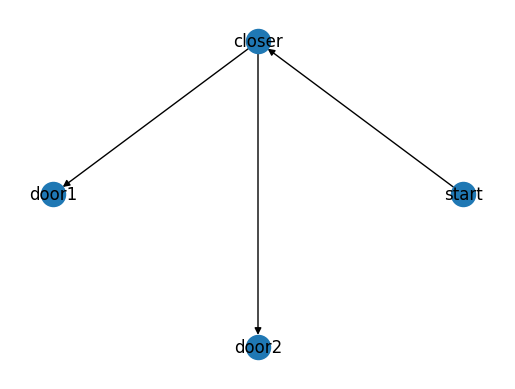

In [ ]:
outline = InteractiveStory.from_outline_yaml(ship_path)
draw_graph(build_story_graph(outline))

##### Fake Generation
Generate story with a fake llm in order to see all the paths spinayarn *walks*

In [ ]:
generator = SpinAYarn(llm=fake_llm, story_outline=outline)
story = generator.generate_story()

building text for paths:   0%|          | 0/3 [00:00<?, ?it/s]

start>closer:   0%|          | 0/2 [00:00<?, ?it/s]

start>closer>door1:   0%|          | 0/3 [00:00<?, ?it/s]

start>closer>door2:   0%|          | 0/3 [00:00<?, ?it/s]

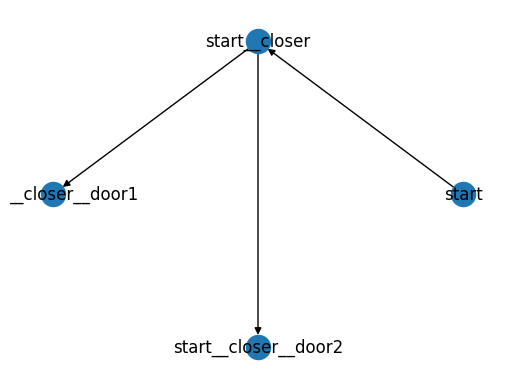

In [ ]:
draw_graph(build_story_graph(story))

The generated graph is not too complicated because the story is so simple. But, we can still see that the node names are changed to match the path dependence.

##### Actual Generation
Let's generate the story for real!
We'll use the shorter way this time.

In [ ]:
story = generate_story_from_outline(ship_path, llm)

[+] parsing story yaml file...
[+] generating all shortest paths through story...
[+] cumulatively generating story text for each node in each path...


building text for paths:   0%|          | 0/3 [00:00<?, ?it/s]

start>closer:   0%|          | 0/2 [00:00<?, ?it/s]

Llama.generate: prefix-match hit


start>closer>door1:   0%|          | 0/3 [00:00<?, ?it/s]

Llama.generate: prefix-match hit


start>closer>door2:   0%|          | 0/3 [00:00<?, ?it/s]

Llama.generate: prefix-match hit


[+] Exporting generated story
[+] wrote story to JSON file: examples/abandoned_ship/abandoned_ship.json
[+] wrote story to Twee3 file: examples/abandoned_ship/abandoned_ship.twee


Let's look at the generated story

In [ ]:
!head -n 20 ./examples/abandoned_ship/abandoned_ship.twee

:: StoryTitle
Abandoned Ship

:: StoryData
{
  "ifid": "82cd700e-0e24-11ee-8068-0242ac1c000c",
  "format": "Chapbook",
  "format-version": "1.2.3",
  "start": "start",
  "zoom": 1
}

:: start
As I floated through the asteroid belt, scanning for valuable minerals, my trusty spacesuit crackling with static, I spotted something that made my heart race - an ancient, abandoned ship, its metal hull rusted and pitted from years of exposure to the harsh void.
[[get closer|start__closer]]

:: start__closer
As I approached the ancient abandoned ship, its rusted metal hull bearing the faded letters "NASA Hermes Mission 2500," my heart raced with excitement and trepidation. With sweaty hands, I searched for a door, finding two locked ones that barred my way into the unknown depths of the ship's dark interior.
[[enter door 1|start__closer__door1]]
[[enter door 2|start__closer__door2]]


Using a tweego linux exec copy in the repo to compile and embed the story!

In [ ]:
!chmod +x ./tweego/tweego
!./tweego/tweego -f chapbook-1 -o examples/abandoned_ship/abandoned_ship.hermes.2023.html examples/abandoned_ship/abandoned_ship.twee

In [ ]:
from IPython.core.display import display, HTML
with open("./examples/abandoned_ship/abandoned_ship.hermes.2023.html", "r") as f:
  display(HTML(f.read()))
# NOTE: Restart button doesn't work in notebooks
# Must press restart as well as re-execute cell to restart

#### Hack And Slash

In [ ]:
# Need longer context for this story
llm = get_llamacpp_llm(MODEL_FILE_PATH, n_ctx=2048, seed=2023, verbose=True)

AVX = 1 | AVX2 = 1 | AVX512 = 0 | AVX512_VBMI = 0 | AVX512_VNNI = 0 | FMA = 1 | NEON = 0 | ARM_FMA = 0 | F16C = 1 | FP16_VA = 0 | WASM_SIMD = 0 | BLAS = 1 | SSE3 = 1 | VSX = 0 | 


In [ ]:
yml_path = "./examples/hack_and_slash/hack_and_slash.yml"
story = generate_story_from_outline(yml_path, llm)

[+] parsing story yaml file...
[+] generating all shortest paths through story...
[+] cumulatively generating story text for each node in each path...


building text for paths:   0%|          | 0/17 [00:00<?, ?it/s]

start>fire:   0%|          | 0/2 [00:00<?, ?it/s]

Llama.generate: prefix-match hit


start>fire>bow:   0%|          | 0/3 [00:00<?, ?it/s]

Llama.generate: prefix-match hit


start>fire>bow>silence>wait>sword:   0%|          | 0/6 [00:00<?, ?it/s]

Llama.generate: prefix-match hit
Llama.generate: prefix-match hit
Llama.generate: prefix-match hit


start>fire>sword:   0%|          | 0/3 [00:00<?, ?it/s]

Llama.generate: prefix-match hit


start>fire>bow>silence>wait>sword>bandits:   0%|          | 0/7 [00:00<?, ?it/s]

Llama.generate: prefix-match hit


start>fire>bow>silence>bandits:   0%|          | 0/5 [00:00<?, ?it/s]

Llama.generate: prefix-match hit


start>fire>sword>bandits:   0%|          | 0/4 [00:00<?, ?it/s]

Llama.generate: prefix-match hit


start>fire>bow>silence>wait>sword>bandits>fight:   0%|          | 0/8 [00:00<?, ?it/s]

Llama.generate: prefix-match hit


start>fire>bow>silence>bandits>fight:   0%|          | 0/6 [00:00<?, ?it/s]

Llama.generate: prefix-match hit


In [ ]:
!head -n 20 ./examples/hack_and_slash/hack_and_slash.twee

In [ ]:
!chmod +x ./tweego/tweego
!./tweego/tweego -f chapbook-1 -o examples/hack_and_slash/hack_and_slash.hermes.2023.html examples/hack_and_slash/hack_and_slash.twee

#### Restaurant

In [ ]:
yml_path = "./examples/restaurant/restaurant.yml"
story = generate_story_from_outline(yml_path, llm)

In [ ]:
!head -n 20 ./examples/restaurant/restaurant.twee

In [ ]:
!chmod +x ./tweego/tweego
!./tweego/tweego -f chapbook-1 -o examples/restaurant/restaurant.hermes.2023.html examples/restaurant/restaurant.twee